In [1]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.preprocessing import normalize

import torch
import torch.nn.functional as F

from pytorch_metric_learning.distances import SNRDistance

from src.data.utils import load_mnist_dataset, load_cifar10_dataset
from src.metrics import return_distances, return_distances_label_wise

import plotly_express as px
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

<module 'plotly.version' from '/home/rvdmerwe/Desktop/measuring-manifold-quality/env/lib/python3.9/site-packages/plotly/version.py'>


In [25]:
dataset='cifar10'
optim='adam'
adverserial=True
p=2

if dataset=='cifar10':
    classes = {0:'airplane',
               1:'automobile',
               2:'bird',
               3:'cat',
               4:'deer',
               5:'dog',
               6:'frog',
               7:'horse',
               8:'ship',
               9:'truck',}
else:
    classes = {0:'Digit=0',
               1:'Digit=1',
               2:'Digit=2',
               3:'Digit=3',
               4:'Digit=4',
               5:'Digit=5',
               6:'Digit=6',
               7:'Digit=7',
               8:'Digit=8',
               9:'Digit=9',}
    
    
models = [
    f'xent_{dataset}',
    f'tripent_{dataset}',
    f'trip_sup_{dataset}',
    f'ntxent_{dataset}',
    f'trip_{dataset}',
    f'random_init'
]

models_nice_name = [
    'Cross-Entropy',
    'Triplet-Entropy',
    'Triplet-Supervised',
    'NT-XENT',
    'Triplet-Loss',
    'Random'
]

models_plot = [
    f'xent_{dataset}',
    f'tripent_{dataset}',
    f'trip_sup_{dataset}',
    f'ntxent_{dataset}',
    f'trip_{dataset}',
    f'random_init'
]


cols = ['#003f5c', '#5ab81c', '#b853ae', '#b83014', '#3f94b8', '#de425b']
colors = {m:c for m, c in zip(models,cols)}
nice_names = {m:mn for m, mn in zip(models,models_nice_name)}

In [26]:
if adverserial:
    low_level_label = pd.read_csv(f'../results/distances/results_{dataset}_pgd_p-{p}_plot_label_data.csv')
    low_level = pd.read_csv(f'../results/distances/results_{dataset}_pgd_p-{p}_plot_data.csv')
    high_level_label = pd.read_csv(f'../results/distances/results_{dataset}_pgd_p-{p}_high_level_label_data.csv')
    high_level = pd.read_csv(f'../results/distances/results_{dataset}_pgd_p-{p}_high_level_data.csv')
    alterations = list(range(30))
    xlabel = 'PGD Iterations'
else:
    low_level_label = pd.read_csv(f'../results/distances/results_{dataset}_noise_p-{p}_plot_label_data.csv')
    low_level = pd.read_csv(f'../results/distances/results_{dataset}_noise_p-{p}_plot_data.csv')
    high_level_label = pd.read_csv(f'../results/distances/results_{dataset}_noise_p-{p}_high_level_label_data.csv')
    high_level = pd.read_csv(f'../results/distances/results_{dataset}_noise_p-{p}_high_level_data.csv')
    alterations = np.linspace(0,1,100)
    xlabel = 'Noise Epsilon'

In [27]:
# for embedding_dim in [16,32,64,128,256,512]:
#     plt.figure(figsize=(35,15))
#     plt.rcParams.update({'font.size': 20})
#     plt.suptitle(f'Embedding dim = {embedding_dim}')
#     for label in tqdm(low_level_label.label.unique()):
#         plt.subplot(2,5,label+1)
#         for model in low_level_label.model.unique():
#             if model in models_plot:
#                 data = low_level_label[
#                     (low_level_label.embedding_dim==embedding_dim)&
#                     (low_level_label.model==model)&
#                     (low_level_label.label==label)&
#                     (low_level_label.optim==optim)
#                 ].sort_values('alteration')

#                 plt.errorbar(
#                     [alterations[i] for i in data.alteration],
#                     data.original_pct_change_mean, 
#                     yerr=data.original_pct_change_std_error / np.sqrt(len(data)),
#                     label=nice_names[model],
#                     fmt='-o',
# #                     color=colors[model]
#                 )

#         plt.title(f'{classes[label]}')
#         if label==4:
#             plt.legend(prop={'size': 15}, loc=7 )
#         if label==0 or label==5:
#             plt.ylabel('Percantage difference between distances')
#         plt.xlabel(xlabel)
#     plt.show()

In [28]:
high_level

,total_spikes_average,total_spikes_std_error,total_spikes_average_previous,total_spikes_std_error_previous,total_spikes,total_spikes_revious,average_spike,average_spike_std_error,average_spike_previous,average_spike_previous_std_error,...,total_distance_moved_average,total_distance_moved_std_error,average_distance_increase,average_distance_increase_previous,average_distance_increase_previous_std_error,model,embedding_dim,optim,alteration_type,p
0,8.598430e+00,4.957324e+00,2.120259e+01,8.357918e+00,8.598430e+04,2.120259e+05,0.307087,0.177047,0.757235,0.149151,...,22.320574,4.325366,0.769675,0.471164,0.471164,xent_cifar10,128,adam,pgd,2
1,4.104293e+01,6.467761e+01,1.046376e+02,8.000948e+01,4.104293e+05,1.046376e+06,1.465819,2.309915,3.737059,0.329230,...,26.416065,9.547678,0.910899,0.565030,0.565030,tripent_cifar10,128,adam,pgd,2
2,1.322139e+02,2.542766e+02,1.604693e+02,2.543152e+02,1.288160e+06,1.538580e+06,4.721926,9.081308,5.731046,0.397335,...,16.332178,11.522709,0.563179,0.485521,0.485521,trip_sup_cifar10,128,adam,pgd,2
3,2.260031e+00,9.875984e-01,1.926024e+01,9.319640e+00,2.260031e+04,1.926024e+05,0.080715,0.035271,0.687866,0.123625,...,40.342342,3.585129,1.391115,0.561003,0.561003,ntxent_cifar10,128,adam,pgd,2
4,5.974240e+01,2.826584e+02,7.214861e+01,2.825979e+02,5.488535e+05,6.628293e+05,2.133657,10.094943,2.576736,0.209745,...,40.151093,6.082612,1.384521,0.362930,0.362930,trip_cifar10,128,adam,pgd,2
5,5.243421e+00,1.642627e+00,1.308541e+01,3.612743e+00,5.243421e+04,1.308541e+05,0.187265,0.058665,0.467336,0.007245,...,0.952680,0.210094,0.032851,0.009903,0.009903,random_init,128,adam,pgd,2
6,8.590905e+00,5.377524e+00,2.274057e+01,9.456812e+00,8.590905e+04,2.274057e+05,0.306818,0.192054,0.812163,0.140213,...,19.791264,4.066163,0.682457,0.400821,0.400821,xent_cifar10,1024,adam,pgd,2
7,3.128214e+01,4.387141e+01,8.683397e+01,6.526332e+01,3.128214e+05,8.683397e+05,1.117219,1.566836,3.101213,0.321166,...,26.447368,9.313804,0.911978,0.577625,0.577625,tripent_cifar10,1024,adam,pgd,2
8,1.447735e+02,3.399549e+02,1.774488e+02,3.684498e+02,1.447735e+06,1.774488e+06,5.170481,12.141246,6.337456,0.398422,...,17.286991,11.554230,0.596103,0.528297,0.528297,trip_sup_cifar10,1024,adam,pgd,2
9,2.356824e+00,1.009726e+00,1.768646e+01,6.995930e+00,2.356824e+04,1.768646e+05,0.084172,0.036062,0.631659,0.116346,...,39.731163,3.374031,1.370040,0.647584,0.647584,ntxent_cifar10,1024,adam,pgd,2


'light' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [29]:
high_level_label['model'] = high_level_label['model'].apply(lambda x: nice_names[x])
high_level['model'] = high_level['model'].apply(lambda x: nice_names[x])

In [30]:
high_level_label.T

,0,1,2,3,4,5,6,7,8,9,...,230,231,232,233,234,235,236,237,238,239
total_spikes_average,8.212089,11.776116,7.394627,6.789089,7.277585,7.610343,8.500531,8.861865,9.916086,9.645953,...,6.931862,7.955411,7.414228,8.125655,7.667034,8.046454,7.71321,8.789323,8.03466,8.231393
total_spikes_std_error,4.374563,6.717543,4.071729,3.941696,3.621991,3.854722,4.503078,4.750264,5.355678,5.409762,...,3.623559,3.582599,3.288458,3.521055,3.203825,3.402067,2.978941,3.618313,3.676448,3.564811
total_spikes_average_previous,20.784653,21.250738,21.926327,21.741762,22.100433,23.276213,20.130054,19.674183,19.926035,21.2155,...,15.253707,17.254475,18.240321,18.52918,19.631319,18.369988,20.406108,19.091548,16.793606,17.755231
total_spikes_std_error_previous,8.179044,7.706187,9.170524,8.938594,9.226289,9.990317,7.592031,6.746954,6.900072,7.832816,...,6.972076,5.66581,6.343427,6.250729,5.815288,6.162096,5.598543,5.5666,5.660833,5.55948
total_spikes,8212.088867,11776.116211,7394.626953,6789.088867,7277.584961,7610.342773,8500.53125,8861.865234,9916.085938,9645.953125,...,6931.861895,7955.411254,7414.22789,8125.655294,7667.033815,8046.454444,7713.209766,8789.322505,8034.660121,8231.392734
total_spikes_revious,20784.652344,21250.738281,21926.326172,21741.761719,22100.433594,23276.212891,20130.054688,19674.183594,19926.035156,21215.5,...,15253.7072,17254.475203,18240.320882,18529.18017,19631.318724,18369.988164,20406.107579,19091.547951,16793.605865,17755.230699
average_spike,0.293289,0.420576,0.264094,0.242467,0.259914,0.271798,0.30359,0.316495,0.354146,0.344498,...,0.247566,0.284122,0.264794,0.290202,0.273823,0.287373,0.275472,0.313904,0.286952,0.293978
average_spike_std_error,0.156234,0.239912,0.145419,0.140775,0.129357,0.137669,0.160824,0.169652,0.191274,0.193206,...,0.129413,0.12795,0.117445,0.125752,0.114422,0.121502,0.106391,0.129225,0.131302,0.127315
average_spike_previous,0.742309,0.758955,0.783083,0.776491,0.789301,0.831293,0.71893,0.702649,0.711644,0.757696,...,0.544775,0.616231,0.65144,0.661756,0.701119,0.656071,0.72879,0.681841,0.599772,0.634115
average_spike_previous_std_error,0.157424,0.135696,0.147851,0.18237,0.1368,0.151797,0.128511,0.137799,0.143068,0.150693,...,0.012286,0.011461,0.012753,0.012174,0.012469,0.011732,0.01201,0.011617,0.01209,0.011164


<Figure size 1800x1080 with 0 Axes>

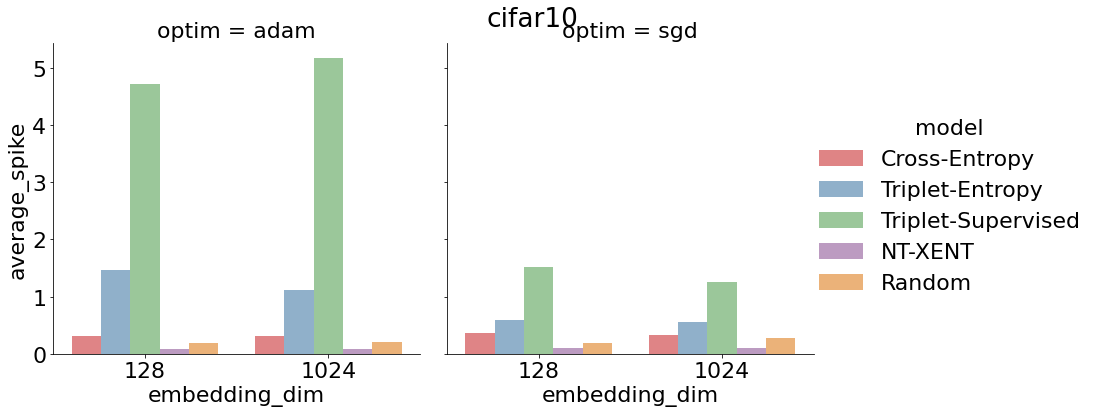

<Figure size 1080x1080 with 0 Axes>

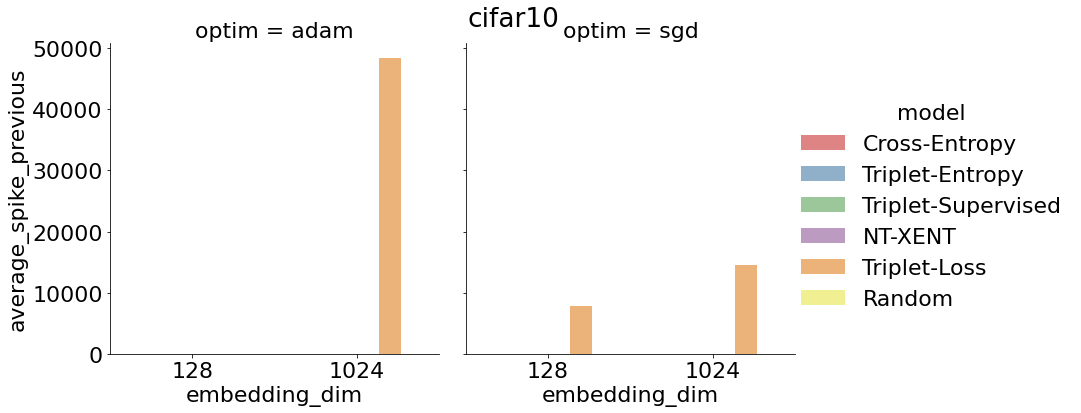

<Figure size 1080x1080 with 0 Axes>

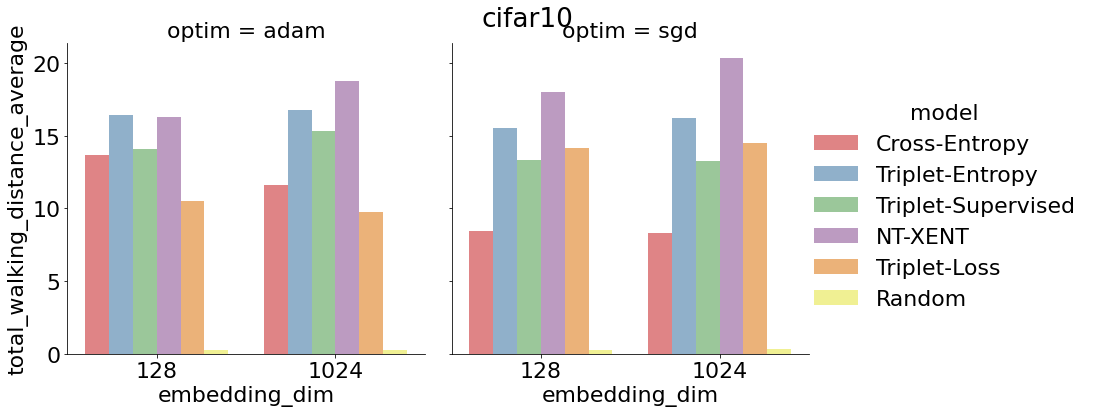

<Figure size 1080x1080 with 0 Axes>

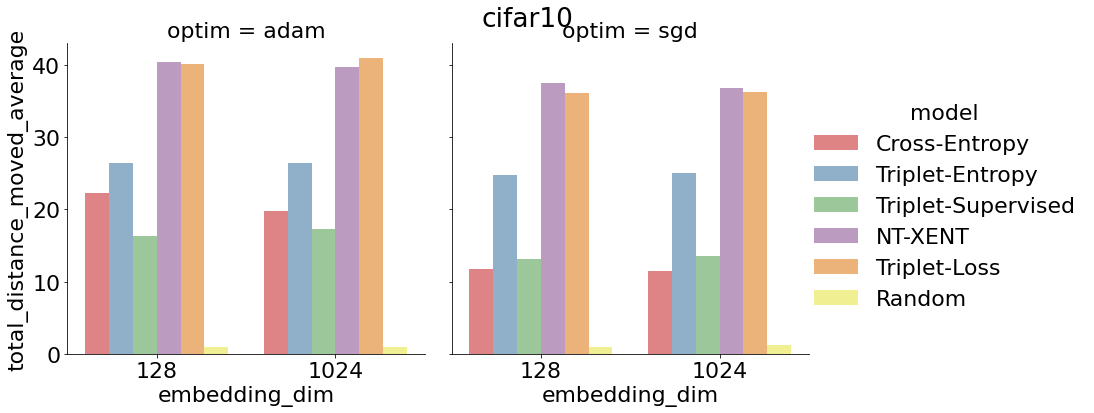

<Figure size 1080x1080 with 0 Axes>

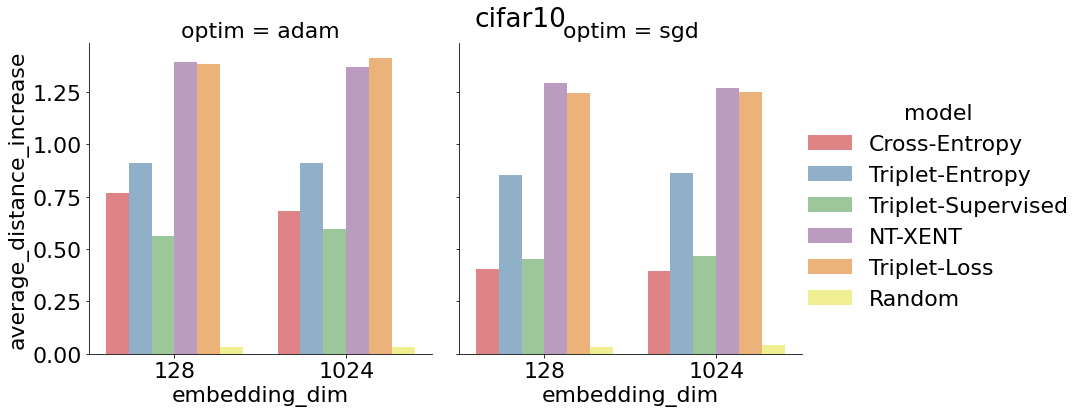

<Figure size 1080x1080 with 0 Axes>

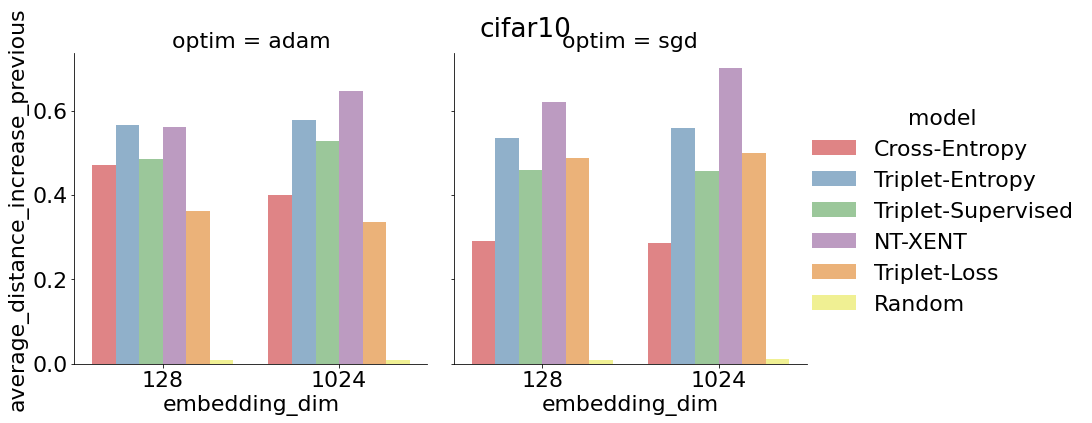

In [35]:
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(25,15))
sns.catplot(
    data=high_level[high_level.model!='Triplet-Loss'],
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="average_spike",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()


plt.figure(figsize=(15,15))
sns.catplot(
    data=high_level,
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="average_spike_previous",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()

plt.figure(figsize=(15,15))
sns.catplot(
    data=high_level,
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="total_walking_distance_average",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()

plt.figure(figsize=(15,15))
sns.catplot(
    data=high_level,
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="total_distance_moved_average",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()

plt.figure(figsize=(15,15))
sns.catplot(
    data=high_level,
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="average_distance_increase",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()

plt.figure(figsize=(15,15))
sns.catplot(
    data=high_level,
    kind="bar",
    x="embedding_dim",
    col='optim',
    y="average_distance_increase_previous",
    hue="model",
#     row='label',
    palette="Set1",
    alpha=.6,
    height=6
)
plt.suptitle(dataset)
plt.show()



# plt.figure(figsize=(15,10))
# sns.catplot(
#     data=high_level,
#     kind="bar",
#     x="embedding_dim",
#     col='optim',
#     y="average_spike",
#     hue="model",
# #     row='label',
#     palette="Set1",
#     alpha=.6,
#     height=6
# )
# plt.suptitle('MNIST')
# plt.show()